---
title: Logistic Regression I
---

::: {note} Learning Outcomes
* Understand the difference between regression and classification
* Derive the logistic regression model for classifying data
* Understand the meaning of decision boundaries at chosen thresholds
:::

Up until this point in the class , we've focused on **regression** tasks - that is, predicting an *unbounded numerical quantity* from a given dataset. We discussed optimization, feature engineering, and regularization all in the context of performing regression to predict some quantity. 

Now that we have this deep understanding of the modeling process, let's expand our knowledge of possible modeling tasks. 

## Classification

In the next two lectures, we'll tackle the task of **classification**. A classification problem aims to classify data into  *categories*. Unlike in regression, where we predicted a numeric output, classification involves predicting some **categorical variable**, or **response**, $y$. Examples of classification tasks include:

* Predicting which team won from its turnover percentage 
* Predicting the day of the week of a meal from the total restaurant bill 
* Predicting the model of car from its horsepower

There are a couple of different types of classification:

* **Binary classification**: classify data into two classes, and responses $y$ are either 0 or 1
* **Multiclass classification**: classify data into multiple classes (e.g., image labeling, next word in a sentence, etc.)

We can further combine multiple related classfication predictions (e.g., translation, voice recognition, etc.) to tackle complex problems through structured prediction tasks.

In Data 100, we will mostly deal with **binary classification**, where we are attempting to classify data into one of two classes. 

### Modeling Process
To build a classification model, we need to modify our modeling workflow slightly. Recall that in regression we:

1. Created a design matrix of numeric features
2. Defined our model as a linear combination of these numeric features
3. Used the model to output numeric predictions

In classification, however, we no longer want to output numeric predictions; instead, we want to predict the class to which a datapoint belongs. This means that we need to update our workflow. To build a classification model, we will:

1. Create a design matrix of numeric features.
2. Define our model as a linear combination of these numeric features, transformed by a non-linear **sigmoid function**. This outputs a numeric quantity.
3. Apply a **decision rule** to interpret the outputted quantity and decide a classification.
4. Output a predicted class.

There are two key differences: as we'll soon see, we need to incorporate a non-linear transformation to capture the non-linear relationships hidden in our data. We do so by applying the sigmoid function to a linear combination of the features. Secondly, we must apply a decision rule to convert the numeric quantities computed by our model into an actual class prediction. This can be as simple as saying that any datapoint with a feature greater than some number $x$ belongs to Class 1.

**Regression:**

```{image} images/reg.png
:alt: Overview of regression: You start with an input of numeric features, apply a model (linear combination), and then get a numeric prediction as output.
:width: 750
```

**Classification:**

```{image} images/class.png
:alt: Overview of classification: You start with an input of numeric features, apply a model (linear combination transformed by non-linear sigmoid), apply a decision rule, and then get a class as output.
:width:750
```

This was a very high-level overview. Let's walk through the process in detail to clarify what we mean.

::: {tip} Terminology

An important note: despite its name, logistic regression is used for *classification* tasks, not regression tasks. In Data 100, we always apply logistic regression with the goal of classifying data.

:::

## The Logistic Regression Model

Throughout this lecture, we will work with the `games` dataset, which contains information about games played in the NBA basketball league. Our goal will be to use a basketball team's `"GOAL_DIFF"` to predict whether or not a given team won their game (`"WON"`). If a team wins their game, we'll say they belong to Class 1. If they lose, they belong to Class 0.

For those who are curious, `"GOAL_DIFF"` represents the difference in successful field goal percentages between the two competing teams. 

````{dropdown} Click to see the code
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.seterr(divide='ignore')

games = pd.read_csv("data/games").dropna()
games.head()
```
````

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.seterr(divide='ignore')

games = pd.read_csv("data/games").dropna()
games.head()

,GAME_ID,TEAM_NAME,MATCHUP,WON,GOAL_DIFF,AST
0,21701216,Dallas Mavericks,DAL vs. PHX,0,-0.251,20
1,21700846,Phoenix Suns,PHX @ GSW,0,-0.237,13
2,21700071,San Antonio Spurs,SAS @ ORL,0,-0.234,19
3,21700221,New York Knicks,NYK @ TOR,0,-0.234,17
4,21700306,Miami Heat,MIA @ NYK,0,-0.222,21


Let's visualize the relationship between `"GOAL_DIFF"` and `"WON"` using the Seaborn function `sns.stripplot`. A strip plot automatically introduces a small amount of random noise to **jitter** the data. Recall that all values in the `"WON"` column are either 1 (won) or 0 (lost) – if we were to directly plot them without jittering, we would see severe overplotting.

````{dropdown} Click to see the code
```python
#| fig-alt: In the plot, the blob of blue datapoints is centered to the left of the blob of orange datapoints. There is a significant amount of overlap in x values between the two blobs.
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", hue='WON', alpha=0.7)
# By default, sns.stripplot plots 0, then 1. We invert the y axis to reverse this behavior
plt.gca().invert_yaxis();
```
````

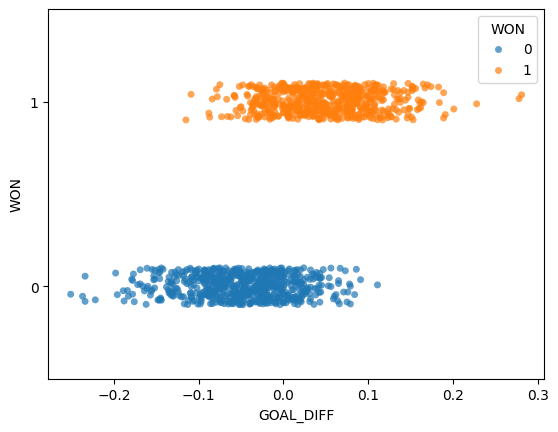

In [2]:
#| fig-alt: In the plot, the blob of blue datapoints is centered to the left of the blob of orange datapoints. There is a significant amount of overlap in x values between the two blobs.
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", hue='WON', alpha=0.7)
# By default, sns.stripplot plots 0, then 1. We invert the y axis to reverse this behavior
plt.gca().invert_yaxis();

This dataset is unlike anything we've seen before – our target variable contains only two unique values! (Remember that each y value is either 0 or 1; the plot above jitters the y data slightly for ease of reading.)

The regression models we have worked with always assumed that we were attempting to predict a continuous target. If we apply a linear regression model to this dataset, something strange happens.

````{dropdown} Click to see the code
```python
#| fig-alt: Now a linear regression has been overlaid on the plot.
import sklearn.linear_model as lm

X, Y = games[["GOAL_DIFF"]], games["WON"]
regression_model = lm.LinearRegression()
regression_model.fit(X, Y)

plt.plot(X.squeeze(), regression_model.predict(X), "k")
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", hue='WON', alpha=0.7)
plt.gca().invert_yaxis();
```
````

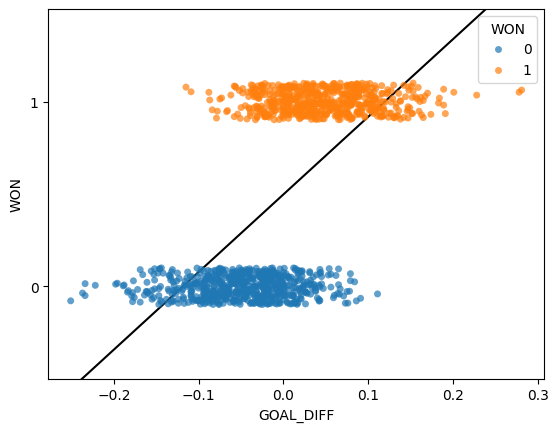

In [3]:
#| fig-alt: Now a linear regression has been overlaid on the plot.
import sklearn.linear_model as lm

X, Y = games[["GOAL_DIFF"]], games["WON"]
regression_model = lm.LinearRegression()
regression_model.fit(X, Y)

plt.plot(X.squeeze(), regression_model.predict(X), "k")
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", hue='WON', alpha=0.7)
plt.gca().invert_yaxis();

The linear regression fit follows the data as closely as it can. However, this approach has a key flaw - the predicted output, $\hat{y}$, can be outside the range of possible classes (there are predictions above 1 and below 0). This means that the output can't always be interpreted (what does it mean to predict a class of -2.3?).

Our usual linear regression framework won't work here. Instead, we'll need to get more creative.

### Graph of Averages

Back in [Data 8](https://inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column.html#example-prediction), you gradually built up to the concept of linear regression by using the **graph of averages**. Before you knew the mathematical underpinnings of the regression line, you took a more intuitive approach: you bucketed the $x$ data into bins of common values, then computed the average $y$ for all datapoints in the same bin. The result gave you the insight needed to derive the regression fit.

Let's take the same approach as we grapple with our new classification task. In the cell below, we 1) bucket the `"GOAL_DIFF"` data into bins of similar values and 2) compute the average `"WON"` value of all datapoints in a bin.

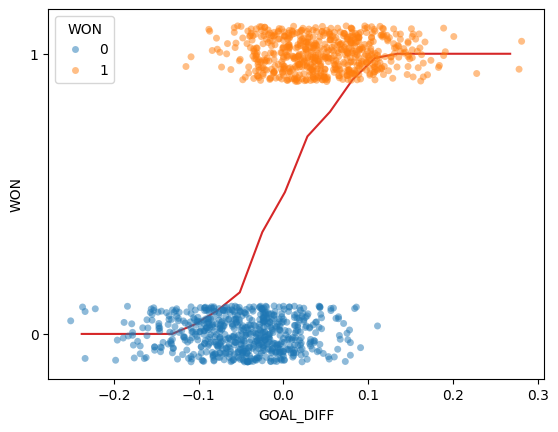

In [4]:
#| fig-alt: A red curve now overlays the data. It starts in the center of the blue blob of datapoints, increases fairly fast, and then ends centered in the orange blob of datapoints.
# bucket the GOAL_DIFF data into 20 bins
bins = pd.cut(games["GOAL_DIFF"], 20)
games["bin"] = [(b.left + b.right) / 2 for b in bins]
win_rates_by_bin = games.groupby("bin")["WON"].mean()

# plot the graph of averages
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.5, hue='WON') # alpha makes the points transparent
plt.plot(win_rates_by_bin.index, win_rates_by_bin, c="tab:red")
plt.gca().invert_yaxis();

Interesting: our result is certainly not like the straight line produced by finding the graph of averages for a linear relationship. We can make two observations:

* All predictions on our line are between 0 and 1
* The predictions are **non-linear**, following a rough "S" shape

Let's think more about what we've just done.

To find the average $y$ value for each bin, we computed:

$$\frac{1 \text{(\# Y = 1 in bin)} + 0 \text{(\# Y = 0 in bin)}}{\text{\# datapoints in bin}} = \frac{\text{\# Y = 1 in bin}}{\text{\# datapoints in bin}} = P(\text{Y = 1} | \text{bin})$$

This is simply the probability of a datapoint in that bin belonging to Class 1! This aligns with our observation from earlier: all of our predictions lie between 0 and 1, just as we would expect for a probability.

Our graph of averages was really modeling the probability, $p$, that a datapoint belongs to Class 1, or essentially that $\text{Y = 1}$ for a particular value of $\text{x}$.

$$ p = P(Y = 1 | \text{ x} )$$

In logistic regression, we have a new modeling goal. We want to model the **probability that a particular datapoint belongs to Class 1** by approximating the S-shaped curve we plotted above. However, we've only learned about linear modeling techniques like Linear Regression and OLS.

### The Sigmoid Function

Let's start by identifying an S-shaped function that maps ($-\infty$, $\infty$) inputs to (0,1) outputs—the **sigmoid ($\sigma$) function**. It is also known as the logistic function or the inverse logit function.

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

```{image} images/sigmoid.png
:alt: The signmoid curve
:width:400
```

As it turns out, the logistic regression model fits a sigmoid function to the data. We can also shift and scale the sigmoid function just as if we were transforming any other function to fit our data:
$$\sigma(\theta_0+\theta x) = \frac{1}{1+e^{-(\theta_0+\theta_1x)}}$$

Note that our input to the sigmoid function here looks exactly like simple linear regression! And just like in ordinary least squares, we're not limited to one input:
$$P(Y=1 \mid x) = \sigma(\theta_0 + \theta_1 x_1 + \theta_2 x_2 ) = \frac{1}{1+e^{-(\theta_0 + \theta_1 x_1 + \theta_2 x_2)}}$$

````{dropdown} Click to see the code
```python
import plotly.graph_objects as go

# Plot a 3D sigmoid surface
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
X1, X2 = np.meshgrid(x1, x2)
y_values = 1/(1 + np.exp(-(X1 + X2)))

# Create a 3D surface plot for the sigmoid function
fig = go.Figure(data=[go.Surface(z=y_values, x=X1[0], y=X2[:, 0])])

# Update layout for better visualization
fig.update_layout(
  title="Sigmoid with two inputs",
  scene=dict(
    xaxis_title="X1",
    yaxis_title="X2",
    zaxis_title="\u03C3(X1, X2)"
  ),
  width=800,
  height=600
)

# Reduce tick label size
fig.update_layout(
    scene=dict(
        xaxis=dict(tickfont=dict(size=14)),
        yaxis=dict(tickfont=dict(size=14)),
        zaxis=dict(tickfont=dict(size=14))
    )
)

fig.show()
```
````

In [5]:
import plotly.graph_objects as go

# Plot a 3D sigmoid surface
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
X1, X2 = np.meshgrid(x1, x2)
y_values = 1/(1 + np.exp(-(X1 + X2)))

# Create a 3D surface plot for the sigmoid function
fig = go.Figure(data=[go.Surface(z=y_values, x=X1[0], y=X2[:, 0])])

# Update layout for better visualization
fig.update_layout(
  title="Sigmoid with two inputs",
  scene=dict(
    xaxis_title="X1",
    yaxis_title="X2",
    zaxis_title="\u03C3(X1, X2)"
  ),
  width=800,
  height=600
)

# Reduce tick label size
fig.update_layout(
    scene=dict(
        xaxis=dict(tickfont=dict(size=14)),
        yaxis=dict(tickfont=dict(size=14)),
        zaxis=dict(tickfont=dict(size=14))
    )
)

fig.show()

Below, we fit a logistic regression model to our data. You do not need to worry about what's going on "under the hood" for now. Just notice how similar the logistic regression model is to our graph of averages.

````{dropdown} Click to see the code
```python
#| fig-alt: The graph of averages curve is extremely similar to the logistic regression model.
# We'll discuss the `LogisticRegression` class next time
xs = np.linspace(-0.3, 0.3)

logistic_model = lm.LogisticRegression(C=20)
logistic_model.fit(X, Y)
predicted_prob = logistic_model.predict_proba(xs[:, np.newaxis])[:, 1]

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.5, hue="WON", legend=False)
plt.plot(xs, predicted_prob, c="k", lw=3, label="Logistic regression model")
plt.plot(win_rates_by_bin.index, win_rates_by_bin, lw=2, c="tab:red", label="Graph of averages")
plt.legend(loc="upper left")
plt.gca().invert_yaxis();
```
````

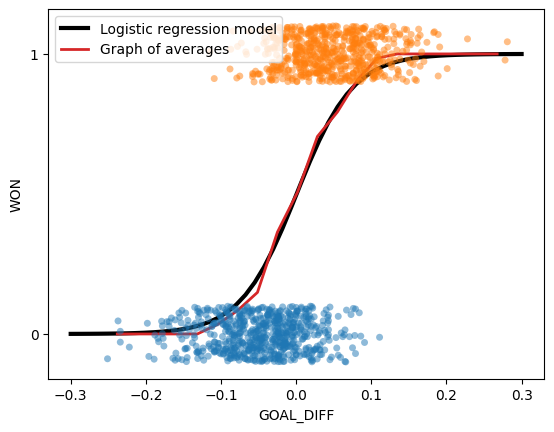

In [6]:
#| fig-alt: The graph of averages curve is extremely similar to the logistic regression model.
# We'll discuss the `LogisticRegression` class next time
xs = np.linspace(-0.3, 0.3)

logistic_model = lm.LogisticRegression(C=20)
logistic_model.fit(X, Y)
predicted_prob = logistic_model.predict_proba(xs[:, np.newaxis])[:, 1]

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.5, hue="WON", legend=False)
plt.plot(xs, predicted_prob, c="k", lw=3, label="Logistic regression model")
plt.plot(win_rates_by_bin.index, win_rates_by_bin, lw=2, c="tab:red", label="Graph of averages")
plt.legend(loc="upper left")
plt.gca().invert_yaxis();

### Formalizing the Logistic Regression Model
Let's now generalize our model to multiple inputs rather than just one or two inputs. The probability of a datapoint belonging to Class 1 is:
$$P(Y=1|x) = \frac{1}{1+e^{-x^T \theta}}  = \frac{1}{1+e^{-(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_p x_p)}}$$

To predict a probability using the logistic regression model, we:

1. Compute a linear combination of the features, $x^{\top}\theta$
2. Apply the sigmoid activation function, $\sigma(x^{\top} \theta)$.

Our main takeaway from this section is that we can:

* Model the **probability $P(Y = 1 | x)$** using a **sigmoid transformation** of a **linear model**

Indeed, the estimated probability that the response is 1 given the features $x$, is equal to the logistic function $\sigma()$ at the value $x^{\top}\theta$:

\begin{align}
\hat{P}_{\theta}(Y = 1 | x) = \frac{1}{1 + e^{-x^{\top}\theta}}
\end{align}

More commonly, the logistic regression model is written as:

\begin{align}
\hat{P}_{\theta}(Y = 1 | x) = \sigma(x^{\top}\theta)
\end{align}


::: {tip} Example Calculation
Suppose we want to predict the probability that a team wins a game, given `"GOAL_DIFF"` (first feature) and the **number of free throws** (second feature). Let's say we fit a logistic regression model (with no intercept) using the training data and estimate the optimal parameters. Now we want to predict the probability that a new team with a `"GOAL_DIFF"` of 15 and 1 free throw per game will win their game.

\begin{align}
\hat{\theta}^{\top} &= \begin{matrix}[0.1 & -0.5]\end{matrix}
\\x^{\top} &= \begin{matrix}[15 & 1]\end{matrix}
\end{align}

\begin{align}
\hat{P}_{\hat{\theta}}(Y = 1 | x) = \sigma(x^{\top}\hat{\theta}) = \sigma(0.1 \cdot 15 + (-0.5) \cdot 1) = \sigma(1) = \frac{1}{1+e^{-1}} \approx 0.7311
\end{align}

We see that the response is more likely to be 1 than 0, indicating that a reasonable prediction is $\hat{y} = 1$. We'll dive deeper into this later.

:::

::: {tip} Properties of the Logistic Model
Consider a logistic regression model with one feature and an intercept term:

\begin{align}
p = P(Y = 1 | x) = \frac{1}{1+e^{-(\theta_0 + \theta_1 x)}}
\end{align}

Properties:

* $\theta_0$ controls the position of the curve along the horizontal axis
* The magnitude of $\theta_1$ controls the "steepness" of the sigmoid
* The sign of $\theta_1$ controls the orientation of the curve

:::

With our logistic regression model formalized, we have 2 natural questions about the parameters that follow:

1. How do we **interpret** the $\theta$'s?
2. How do we **estimate** the $\theta$'s?

We'll dive deep into answering the first question in the next section, and answer the second question in the next lecture.

## Log-Odds and Linearity

### Interpreting Logistic Regression Coefficients

Let's focus on the simple logistic regression model with just one input: $$P(Y=1|x) = \frac{1}{1+e^{-(\theta_0+\theta_1x)}}$$

Recall that in simple linear regression ($y = \theta_0 + \theta_1 x$), we interpret $\theta_1$ as the change in $y$ for a one-unit increase in $x$.
However, in logistic regression, the change in the predicted outcome is not constant for every one-unit increase in $x$ since the sigmoid function is non-linear (not a straight line). To make interpretation a little easier, we can isolate the linear combination $\theta_0 + \theta_1$ using some algebra:
$$\begin{align*}
& P(Y=1 \mid x) = \frac{1}{1+e^{-(\theta_0 + \theta_1 x)}} \\
& 1+e^{-(\theta_0 + \theta_1 x)} = \frac{1}{P(Y=1 \mid x)} \\
& e^{-(\theta_0 + \theta_1 x)} = \frac{1}{P(Y=1 \mid x)} - 1 \\
& e^{-(\theta_0 + \theta_1 x)} = \frac{1 - P(Y=1 \mid x)}{P(Y=1 \mid x)} \\
& e^{\theta_0 + \theta_1 x} = \frac{P(Y=1 \mid x)}{1 - P(Y=1 \mid x)} \\
& \theta_0 + \theta_1 x = \log \left( \frac{P(Y=1 \mid x)}{1 - P(Y=1 \mid x)} \right) 
\end{align*}$$

We have just derived that as $x$ increases by one, $\log \left( \frac{P(Y=1 \mid x)}{1 - P(Y=1 \mid x)} \right)$ increases by $\theta_1$. Does this really have a meaningful interpretation?

To help with our interpretation, consider the expression: "Cal has 10 to 1 odds of winning the game." These $10:1$ odds means that $P(\text{Cal wins}) = 10 \cdot P(\text{Cal loses})$. The **odds** is defined as the probability of a datapoint Y belonging to Class 1 divided by the probability of it belonging to Class 0. 

$$\text{odds} = \frac{P(Y=1|x)}{P(Y=0|x)} = \frac{P(Y=1 \mid x)}{1 - P(Y=1 \mid x)} $$

Great! Now we have a much more meaningful interpretation of the logistic regression coefficients as **log-odds**:

- For every one-unit increase in $x$, $\text{log}(\text{Odds}(Y=1|x))$ increases by $\theta_1$.

### Linearity

To summarize, probability is a **non-linear** function of the features because $P(Y=1|x) =\sigma(x^{\top}\theta)$ applies a non-linear sigmoid transformation to $x^{\top}\theta$. However, we have just found that the log-odds are a **linear** function with respect to the $\theta$'s. Namely, $\text{log}(\text{Odds}(Y=1|x)) = x^{\top}\theta$. Indeed, this means there is linearity in the logistic regression model! This linearity in the log-odds leads to a linear decision boundary between Class 0 and Class 1, which we will explore more in the next section.

## Decision Boundaries
In logistic regression, we model the *probability* that a datapoint belongs to Class 1. 

```{image} images/log_reg_summary.png
:alt: Overview of classification which takes in numeric features and ultimately outputs a class.
:width: 800
```

In this lecture, we developed the logistic regression model to predict that probability, but the model itself does not classify whether a prediction is Class 0 or Class 1.


$$ p = \hat{P}_\theta(Y=1 | x) = \frac{1}{1 + e^{-x^{\top}\theta}}$$

A **decision rule** tells us how to convert model outputs into classifications. We commonly make decision rules by specifying a **threshold**, $T$. If the predicted probability is greater than or equal to $T$, predict Class 1. Otherwise, predict Class 0. 

$$\hat y = \text{classify}(x) = \begin{cases}
        1, & p \ge T\\
        0, & p < T
    \end{cases}$$
    
The threshold is often set to $T = 0.5$, but *not always*. We'll discuss why we might want to use other thresholds  $T \neq 0.5$ later in this lecture and the next.

Using our decision rule, we can define a **decision boundary** as the “line” that splits the data into classes based on its features. For logistic regression, since we are working in $p$ dimensions, the decision boundary is a **hyperplane**—a linear combination of the features in $p$-dimensions—and we can recover it from the log-odds. 

For instance, suppose we decide to classify all new data points with $P(Y=1|x) \geq 0.5$ as Class 1, and all points with $P(Y=1|x) < 0.5$ as Class 0. In other words, we choose 0.5 as our chosen probability threshold. We can calculate our log-odds as follows:
$$\text{log}(\text{Odds}(Y=1|x))=\log \left( \frac{P(Y=1 \mid x)}{1 - P(Y=1 \mid x)} \right) = \log\left(\frac{0.5}{1 - 0.5}\right) = \log(1) = 0$$
This is the same as labeling all points with $\text{log}(\text{Odds}(Y=1|x)) \geq 0$  as Class 1, and all points with $\text{log}(\text{Odds}(Y=1|x)) < 0$ as Class 0. Since $\text{log}(\text{Odds}(Y=1|x)) = x^{\top}\theta$, we have just found that $$\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_p x_p = 0$$ is our **linear decision boundary** for classification given a threshold of 0.5.

For a model with 2 features, the decision boundary is a line in terms of its features. To make it easier to visualize, we've included an example of a 1-dimensional and a 2-dimensional decision boundary below. Notice how the decision boundary predicted by our logistic regression model perfectly separates the points into two classes. Here the color is the *predicted* class, rather than the true class.

```{image} images/decision_boundary.png
:alt: Illustration of how to use the decision boundary in 1D and 2D.
:width: 800
```

In real life, however, that is often not the case, and we often see some overlap between points of different classes across the decision boundary. The *true* classes of the 2D data are shown below: 

```{image} images/decision_boundary_true.png
:alt: A decision boundary is shown in addition to all the true values of the datapoints. Some datapoints are not correctly classified by the decision boundary.
:width: 400
```

As you can see, the decision boundary predicted by our logistic regression does not perfectly separate the two classes. There's a “muddled” region near the decision boundary where our classifier predicts the wrong class. What would the data have to look like for the classifier to make perfect predictions?

## [BONUS] Maximum Likelihood Estimation

It may have seemed like we pulled cross-entropy loss out of thin air. How did we know that taking the negative logarithms of our probabilities would work so well? It turns out that cross-entropy loss is justified by probability theory.

The following section is out of scope, but is certainly an interesting read!

### Building Intuition: The Coin Flip
To build some intuition for logistic regression, let’s look at an introductory example to classification: the coin flip. Suppose we observe some outcomes of a coin flip (1 = Heads, 0 = Tails).

In [7]:
flips = [0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
flips

[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]

A reasonable model is to assume all flips are IID (independent and identically distributed). In other words, each flip has the same probability of returning a 1 (or heads). Let's define a parameter $\theta$, the probability that the next flip is a heads. We will use this parameter to inform our decision for $\hat y$ (predicting either 0 or 1) of the next flip. If $\theta \ge 0.5, \hat y = 1, \text{else } \hat y = 0$.

You may be inclined to say $0.5$ is the best choice for $\theta$. However, notice that we made no assumption about the coin itself. The coin may be biased, so we should make our decision based only on the data. We know that exactly $\frac{4}{10}$ of the flips were heads, so we might guess $\hat \theta = 0.4$. In the next section, we will mathematically prove why this is the best possible estimate.

### Likelihood of Data

Let's call the result of the coin flip a random variable $Y$. This is a Bernoulli random variable with two outcomes. $Y$ has the following distribution: 

$$P(Y = y) = \begin{cases}
        p, \text{if }  y=1\\
        1 - p, \text{if }  y=0
    \end{cases} $$

$p$ is unknown to us. But we can find the $p$ that makes the data we observed the most *likely*.

The probability of observing 4 heads and 6 tails follows the binomial distribution.

$$\binom{10}{4} (p)^4 (1-p)^6$$ 

We define the **likelihood** of obtaining our observed data as a quantity *proportional* to the probability above. To find it, simply multiply the probabilities of obtaining each coin flip.

$$(p)^{4} (1-p)^6$$ 

The technique known as **maximum likelihood estimation** finds the $p$ that maximizes the above likelihood. You can find this maximum by taking the derivative of the likelihood, but we'll provide a more intuitive graphical solution.

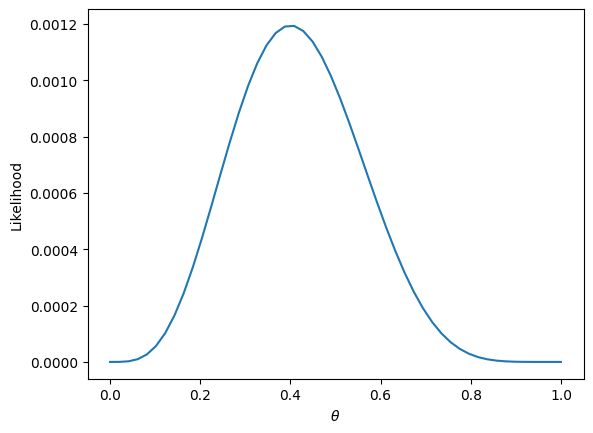

In [8]:
#| fig-alt: Plot showing the liklelihood of each theta, which peaks around 0.4
thetas = np.linspace(0, 1)
plt.plot(thetas, (thetas**4)*(1-thetas)**6)
plt.xlabel(r"$\theta$")
plt.ylabel("Likelihood");

More generally, the likelihood for some Bernoulli($p$) random variable $Y$  is:

$$P(Y = y) = \begin{cases}
        1, \text{with probability }  p\\
        0, \text{with probability }  1 - p
    \end{cases} $$
    
Equivalently, this can be written in a compact way:

$$P(Y=y) = p^y(1-p)^{1-y}$$

- When $y = 1$, this reads $P(Y=y) = p$
- When $y = 0$, this reads $P(Y=y) = (1-p)$

In our example, a Bernoulli random variable is analogous to a single data point (e.g., one instance of a basketball team winning or losing a game). All together, our `games` data consists of many IID Bernoulli($p$) random variables. To find the likelihood of independent events in succession, simply multiply their likelihoods.

$$\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}$$

As with the coin example, we want to find the parameter $p$ that maximizes this likelihood. Earlier, we gave an intuitive graphical solution, but let's take the derivative of the likelihood to find this maximum.

At a first glance, this derivative will be complicated! We will have to use the product rule, followed by the chain rule. Instead, we can make an observation that simplifies the problem. 

Finding the $p$ that maximizes $$\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}$$ is equivalent to the $p$ that maximizes $$\text{log}(\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i})$$

This is because $\text{log}$ is a strictly *increasing* function. It won't change the maximum or minimum of the function it was applied to. From $\text{log}$ properties, $\text{log}(a*b)$ = $\text{log}(a) + \text{log}(b)$. We can apply this to our equation above to get:

$$\underset{p}{\text{argmax}} \sum_{i=1}^{n} \text{log}(p^{y_i} (1-p)^{1-y_i})$$

$$= \underset{p}{\text{argmax}} \sum_{i=1}^{n} (\text{log}(p^{y_i}) + \text{log}((1-p)^{1-y_i}))$$

$$= \underset{p}{\text{argmax}} \sum_{i=1}^{n} (y_i\text{log}(p) + (1-y_i)\text{log}(1-p))$$

We can add a constant factor of $\frac{1}{n}$ out front. It won't affect the $p$ that maximizes our likelihood.

$$=\underset{p}{\text{argmax}}  \frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p) + (1-y_i)\text{log}(1-p)$$

One last "trick" we can do is change this to a minimization problem by negating the result. This works because we are dealing with a *concave* function, which can be made *convex*.

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p) + (1-y_i)\text{log}(1-p)$$

Now let's say that we have data that are independent with different probability $p_i$. Then, we would want to find the $p_1, p_2, \dots, p_n$ that maximize $$\prod_{i=1}^{n} p_i^{y_i} (1-p_i)^{1-y_i}$$

Setting up and simplifying the optimization problems as we did above, we ultimately want to find:

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p_i) + (1-y_i)\text{log}(1-p_i)$$

For logistic regression, $p_i = \sigma(x^{\top}\theta)$. Plugging that in, we get:  

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(\sigma(x^{\top}\theta)) + (1-y_i)\text{log}(1-\sigma(x^{\top}\theta))$$

This is exactly our average cross-entropy loss minimization problem from before! 

Why did we do all this complicated math? We have shown that *minimizing* cross-entropy loss is equivalent to *maximizing* the likelihood of the training data.

- By minimizing cross-entropy loss, we are choosing the model parameters that are "most likely" for the data we observed.

Note that this is under the assumption that all data is drawn independently from the same logistic regression model with parameter $\theta$. In fact, many of the model + loss combinations we've seen can be motivated using MLE (e.g., OLS, Ridge Regression, etc.). In probability and ML classes, you'll get the chance to explore MLE further.  
